<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [24]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [25]:
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [27]:
def get_dataloader(image_size, batch_size):
    dataset = datasets.ImageFolder('/content/drive/MyDrive/face', transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ]))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [28]:
image_size = 64
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_loader = get_dataloader(image_size, batch_size)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [29]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [30]:
discriminator = discriminator.to(device)

In [31]:
latent_size = 64

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [32]:
generator = generator.to(device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [33]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0001
epochs = 30

In [34]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [35]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [36]:
def save_samples(index, latent_tensors, show=True):
    latent_tensors = latent_tensors.to("cuda")
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [37]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [39]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 6.3834, loss_d: 0.1807, real_score: 0.9324, fake_score: 0.0809


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 11.6394, loss_d: 0.0665, real_score: 0.9744, fake_score: 0.0272


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 7.6812, loss_d: 0.3519, real_score: 0.8910, fake_score: 0.1008


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 4.9820, loss_d: 0.3012, real_score: 0.8868, fake_score: 0.1029


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 6.2895, loss_d: 0.0882, real_score: 0.9644, fake_score: 0.0430


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 7.4515, loss_d: 0.1567, real_score: 0.9665, fake_score: 0.0242


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 5.3521, loss_d: 0.2330, real_score: 0.9127, fake_score: 0.0776


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 5.5368, loss_d: 0.2822, real_score: 0.8976, fake_score: 0.0967


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 5.2098, loss_d: 0.2544, real_score: 0.9041, fake_score: 0.0962


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 5.4303, loss_d: 0.3893, real_score: 0.8736, fake_score: 0.1200


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 5.2198, loss_d: 0.3563, real_score: 0.8790, fake_score: 0.1253


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 4.8305, loss_d: 0.2971, real_score: 0.8834, fake_score: 0.1124


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 5.0715, loss_d: 0.2990, real_score: 0.8888, fake_score: 0.1104


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 5.2625, loss_d: 0.3547, real_score: 0.8734, fake_score: 0.1232


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 4.5159, loss_d: 0.3044, real_score: 0.8850, fake_score: 0.1134


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 4.5857, loss_d: 0.3699, real_score: 0.8682, fake_score: 0.1300


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 4.6521, loss_d: 0.3584, real_score: 0.8712, fake_score: 0.1264


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 4.5339, loss_d: 0.3153, real_score: 0.8811, fake_score: 0.1149


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 4.5214, loss_d: 0.4214, real_score: 0.8620, fake_score: 0.1369


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 4.3627, loss_d: 0.2999, real_score: 0.8831, fake_score: 0.1139


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 4.3525, loss_d: 0.3507, real_score: 0.8701, fake_score: 0.1266


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 4.2564, loss_d: 0.3660, real_score: 0.8659, fake_score: 0.1322


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 4.1501, loss_d: 0.3213, real_score: 0.8781, fake_score: 0.1192


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 4.2815, loss_d: 0.3723, real_score: 0.8691, fake_score: 0.1281


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 4.1326, loss_d: 0.3149, real_score: 0.8787, fake_score: 0.1193


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 4.0898, loss_d: 0.3799, real_score: 0.8702, fake_score: 0.1299


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 3.8332, loss_d: 0.2173, real_score: 0.9052, fake_score: 0.0892


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 4.1803, loss_d: 0.3096, real_score: 0.8860, fake_score: 0.1141


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 4.1728, loss_d: 0.3510, real_score: 0.8752, fake_score: 0.1208


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 4.3809, loss_d: 0.2528, real_score: 0.9025, fake_score: 0.0991
Saving generated-images-0030.png


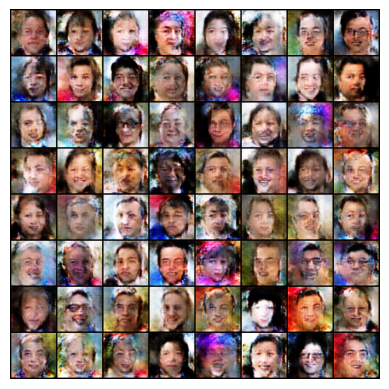

In [40]:
from PIL import Image

image_path = 'generated/generated-images-0030.png'
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

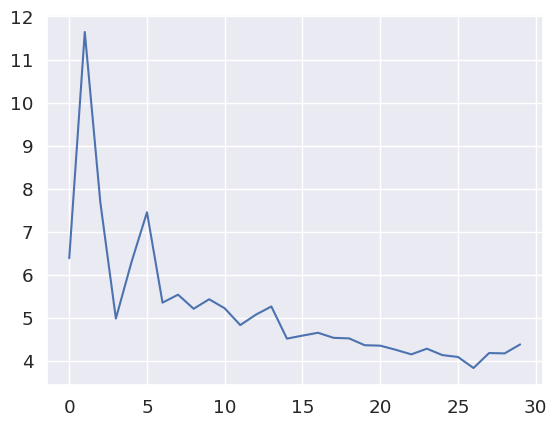

In [41]:
plt.plot(history[0]) #Лосс генератора

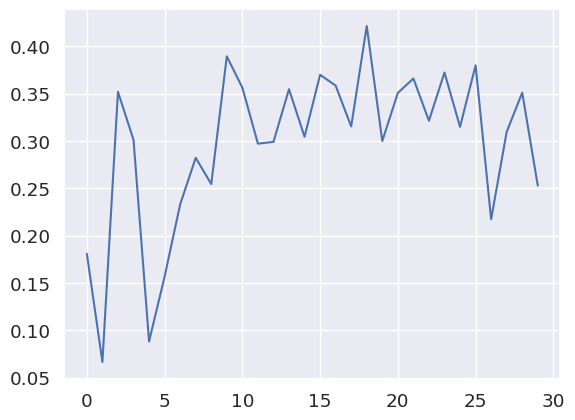

In [42]:
plt.plot(history[1]) #Лосс дискриминатора

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?


Могу сказать, что обучение успешно и генератор научился обманывать дискриминатор

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [46]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [43]:
def show_images(generated):
    plt.figure(figsize=(8, 8))
    images = make_grid(generated.cpu().detach(), nrow=2, normalize=True)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

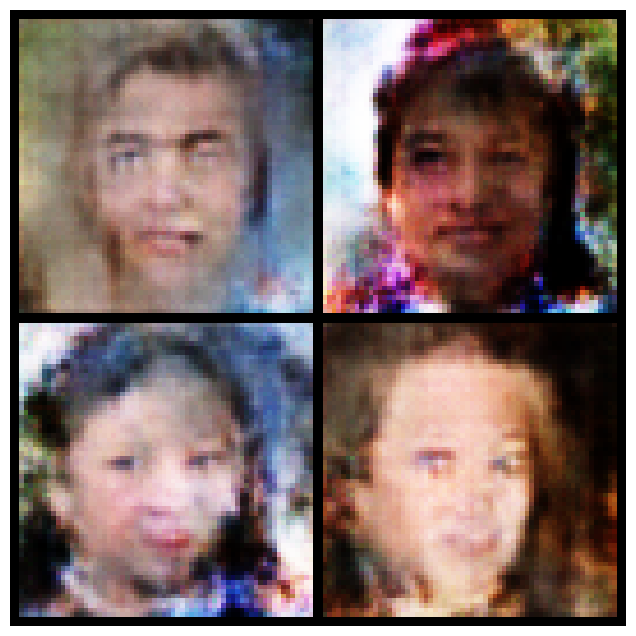

In [47]:
show_images(fake_images)

Как вам качество получившихся изображений?


Лично мне всё нравится. 30 эпох, первая попавшаяся архитектура, притом очень примитивная. Думаю, что результат на 100% оправдан. У меня осталось мало часов GPU для обучения, так что я мало эпох делал

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [53]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

# Определим трансформации и создадим DataLoader
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

real_dataset = ImageFolder('/content/drive/MyDrive/face', transform=transform)

# Генерация фейковых изображений
n_real_images = len(real_dataset)
n_fake_images = n_real_images

fixed_latent = torch.randn(n_fake_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
fake_labels = np.zeros(n_fake_images)  # Метка класса для фейковых изображений

# Получение реальных изображений и их меток
real_images = []
real_labels = []
for i in range(n_real_images):
    if i % 500 == 0:
      print(i)
    img, label = real_dataset[i]
    real_images.append(np.array(img))
    real_labels.append(label)

real_images = np.array(real_images)
real_labels = np.array(real_labels)

# Объединение фейковых и реальных изображений
all_images = np.concatenate([real_images, fake_images.cpu().detach().numpy()])
all_labels = np.concatenate([real_labels, fake_labels])

# Leave-One-Out оценка с k-NN
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

accuracies = []
for train_index, test_index in loo.split(all_images):
    X_train, X_test = all_images[train_index], all_images[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    knn.fit(X_train.reshape(-1, np.prod(X_train.shape[1:])), y_train)
    acc = knn.score(X_test.reshape(1, -1), y_test)
    accuracies.append(acc)

mean_accuracy = np.mean(accuracies)
print(f"Средняя точность leave-one-out оценки с k-NN: {mean_accuracy}")


0
500
1000
1500
2000
2500
3000
Средняя точность leave-one-out оценки с k-NN: 1.0


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Результат бесподобный. Хотели бы получить что-то в районе 0.5, т.к. это уже неплохое значение для сравнение real и fake. Что-то такое было сказано на лекции/семинаре

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Не получилось у меня получить нормальную аккураси, так что тут продолжать не буду)))


Прокомментируйте получившийся результат:

In [ ]:
Всё хорошо!